In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("./data/regression-housing.csv")
df['rating'] = np.random.randint(1, 6, len(df))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
 13  rating            545 non-null    int32 
dtypes: int32(1), int64(6), object(7)
memory usage: 57.6+ KB


In [8]:
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,rating
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,5
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,5
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,5


In [11]:
df.duplicated().sum()


0

## Типи ознак: безперервні, порядкові та категоріальні¶
Результати застосування методу info() показали, що датасет містить тільки числові ознаки, так і не числові ознаки. Дослідники мають бути уважними, адже деякі нечислові ознаки можуть бути закодовані числами. Більше того: для побудови моделей машинного навчання всі ознаки мають бути числовими.

Такі ознаки як mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus є категоріальними. Маємо якимось чином перевести ці ознаки в числові.

Ознаки area, bedrooms, bathrooms, stories, parking відносяться до числових ознак. Вони моожуть трактуватися як числові неперервні. 

Ознака rating може трактуватися як порядкова признака. Наприклад, rating=1 трактується нижче, ніш rating=2 і так далі. 

Переведемо категоріальні ознаки в числові. Використаємо https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [45]:
from sklearn.preprocessing import LabelEncoder

for x in ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']:
    le = LabelEncoder()
    df[x] = le.fit_transform(df[x])
    print(x, le.classes_)

mainroad ['no' 'yes']
guestroom ['no' 'yes']
basement ['no' 'yes']
hotwaterheating ['no' 'yes']
airconditioning ['no' 'yes']
prefarea ['no' 'yes']
furnishingstatus ['furnished' 'semi-furnished' 'unfurnished']


In [46]:
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,rating
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,4
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,4


Проведемо аналіз числових ознак. 

In [47]:
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'rating']

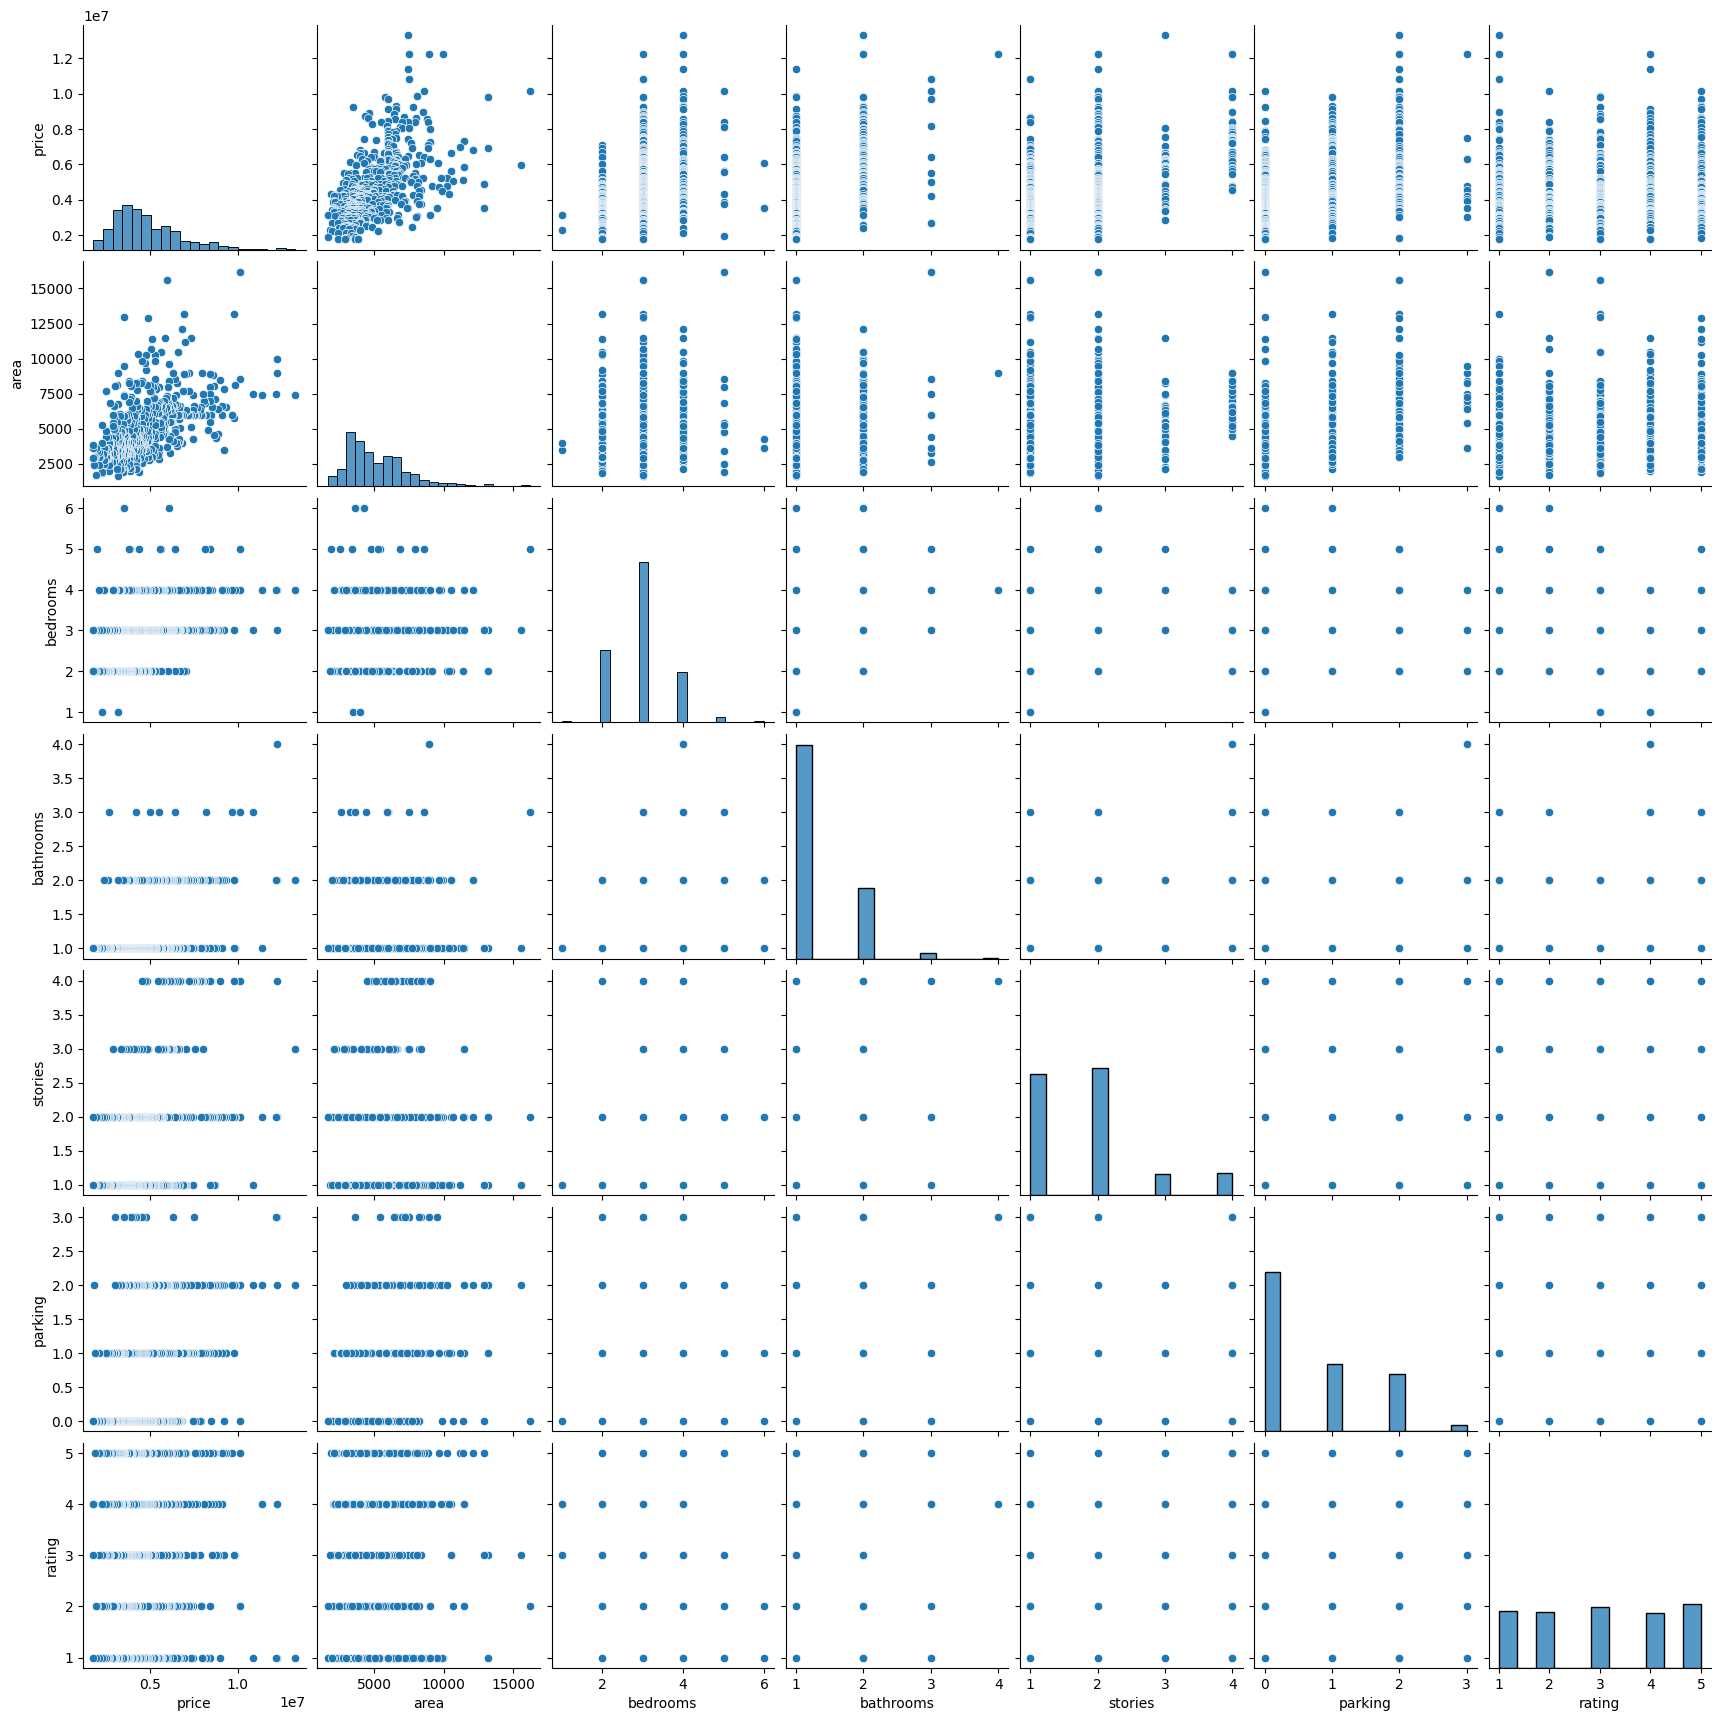

In [48]:
sns.pairplot(df[numeric_cols])
plt.show()

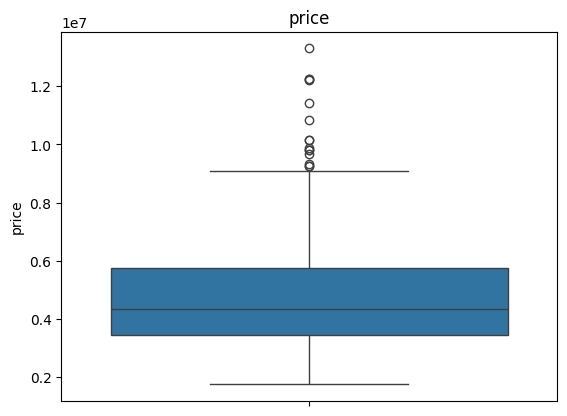

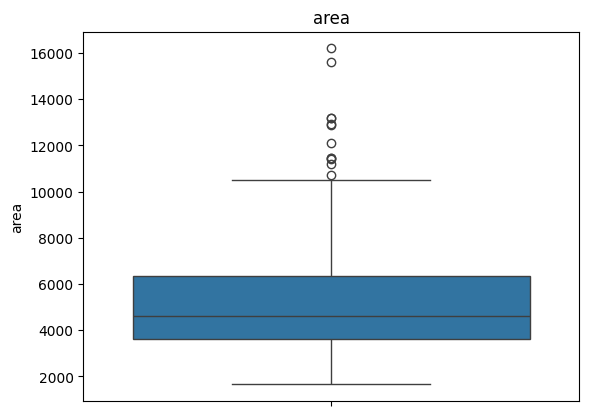

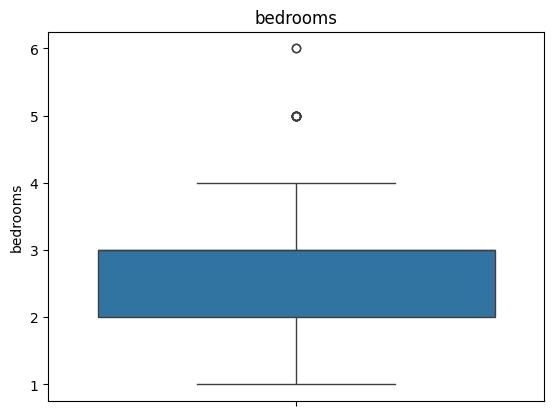

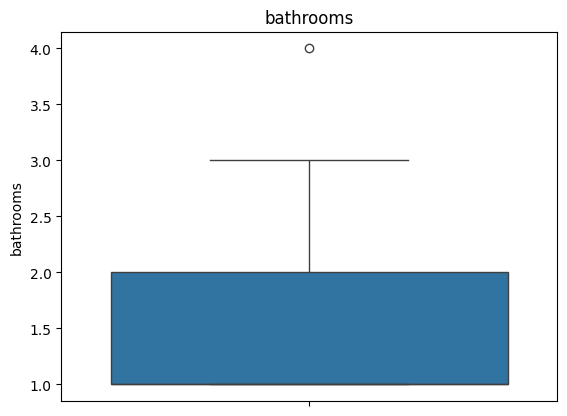

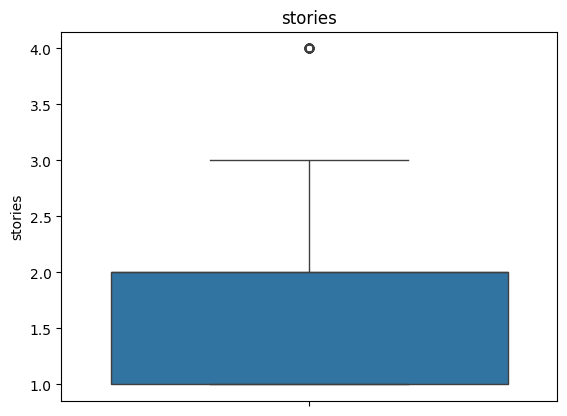

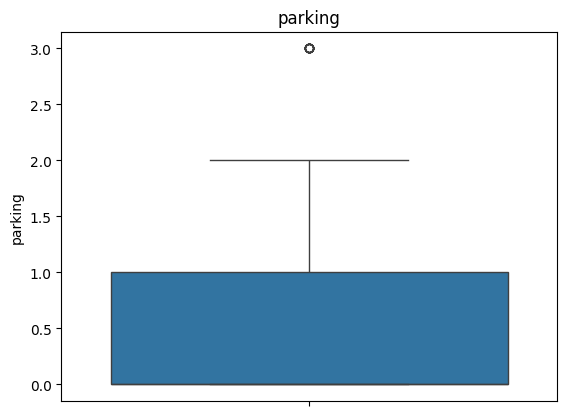

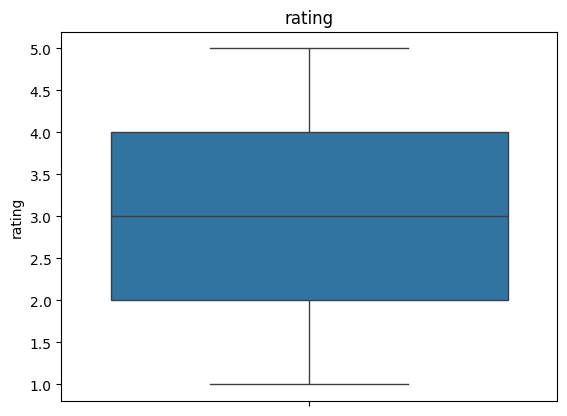

In [49]:
for x in numeric_cols:
    sns.boxplot(df[x])
    plt.title(x)
    plt.show()

Спробуємо зачистити викиди (outliers).

In [50]:
def outliers_indices(df, feature):
    '''
    Let's assume that outliers are the data outside of 3*sigma
    '''
    mid = df[feature].mean()
    sigma = df[feature].std()
    return df[(df[feature] < mid - 3*sigma) | (df[feature] > mid + 3*sigma)].index

In [51]:
wrong_inds = []
for x in numeric_cols:
    wrong_inds.append(
        outliers_indices(df, x)
    )

out = set(wrong_inds[0])
for x in wrong_inds[1:]:
    out |= set(x)

print(len(out))





23


Із набору даних приберуться 23 індекси. В інших датасетах може бути більше.

In [52]:
df.drop(out, inplace=True)

Один із методів подивитись корреляцію між  ознаками -- побудувати матрицю корреляції Спірмена. Даний коефіцієнт корреляції вимірюється тільки для числових ознак.

In [53]:
spi_mat = df[numeric_cols].corr(method='spearman')


<Axes: >

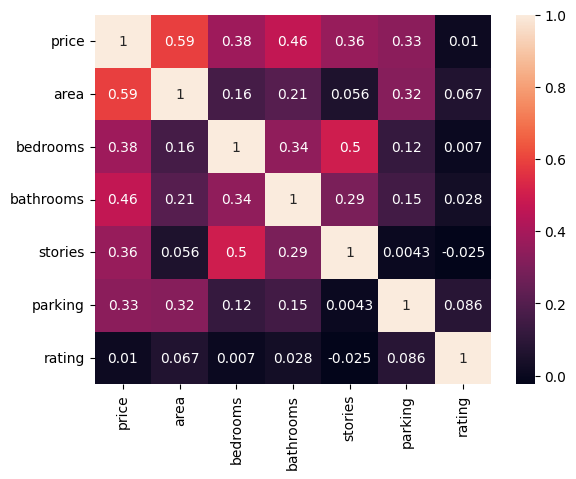

In [54]:
sns.heatmap(spi_mat, annot=True)

Знайдемо статистичну значучість

In [58]:
from scipy.stats import pearsonr, spearmanr, kendalltau

for a, b in [('area', 'price'), ('bedrooms', 'price'), ('stories', 'area')]:
    print(a, b)
    print('pearson', pearsonr(df[a], df[b]))
    print('spearman', spearmanr(df[a], df[b]))
    print('kendall', kendalltau(df[a], df[b]))

area price
pearson PearsonRResult(statistic=0.526353259063527, pvalue=1.5445666137865723e-38)
spearman SignificanceResult(statistic=0.5883457371608684, pvalue=6.262253571620582e-50)
kendall SignificanceResult(statistic=0.4094958931560894, pvalue=7.164906304100881e-44)
bedrooms price
pearson PearsonRResult(statistic=0.3553701743246828, pvalue=5.53648861188084e-17)
spearman SignificanceResult(statistic=0.3769202907334822, pvalue=4.573188883289773e-19)
kendall SignificanceResult(statistic=0.2955053750535894, pvalue=4.811237809894567e-18)
stories area
pearson PearsonRResult(statistic=0.10333081864641427, pvalue=0.01820132060004036)
spearman SignificanceResult(statistic=0.056463424942885365, pvalue=0.19775536477083092)
kendall SignificanceResult(statistic=0.046269650771792355, pvalue=0.174503425925987)


Проаналізуємо категоріальні ознаки

In [59]:
cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

In [60]:
pd.crosstab(df['hotwaterheating'], df['basement'])

basement,0,1
hotwaterheating,,
0,325,174
1,16,7


In [61]:
from scipy.stats import chi2_contingency, fisher_exact
chi2_contingency(pd.crosstab(df['hotwaterheating'], df['basement']))

Chi2ContingencyResult(statistic=0.04532236136063524, pvalue=0.8314123790897295, dof=1, expected_freq=array([[325.97509579, 173.02490421],
       [ 15.02490421,   7.97509579]]))

In [62]:
chi2_contingency(pd.crosstab(df['hotwaterheating'], df['airconditioning']))

Chi2ContingencyResult(statistic=6.920971753278057, pvalue=0.008519067045892288, dof=1, expected_freq=array([[342.22605364, 156.77394636],
       [ 15.77394636,   7.22605364]]))

In [63]:
fisher_exact(pd.crosstab(df['hotwaterheating'], df['airconditioning']))

SignificanceResult(statistic=0.09369771332961517, pvalue=0.0023349877048915177)

Для таблиць 2×2 також існують інші показники ступеня статистичного звʼязку: к. асоціації, к. контингенції, к. колігації, к. Гудмена--Краскала.

Подивимось на взаємозвʼязок між числовою та категоріальною змінними

In [65]:
from scipy.stats import pointbiserialr
pointbiserialr(df['price'], df['hotwaterheating'])

SignificanceResult(statistic=0.0898492925398513, pvalue=0.04016516745957227)

Підказки, який кф використовувати: Pairwise_Correlation_Cheat_Sheet

Посилання на канал, що має гарні пояснення: https://www.youtube.com/watch?v=vemZtEM63GY